In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import regularizers

import keras
from keras.models import Model
from keras.layers import Dropout, Flatten, Input, AveragePooling2D, merge, Activation, ReLU, Lambda
from keras.layers import Conv2D,SeparableConv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate

import tensorflow as tf
#import tensorflow.keras.callbacks.ReduceLROnPlateau

from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train,img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

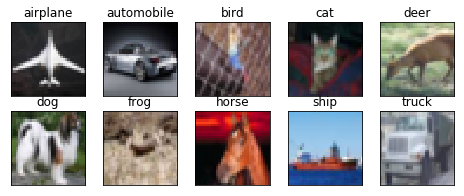

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
#Convert the images in training dataset and test set into multidimentional arrays of their pixel intensity values.

train_features = train_features.reshape(train_features.shape[0], 32, 32,3)
test_features = test_features.reshape(test_features.shape[0], 32, 32,3)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
#This method creates and returns a Group convolution layer consisting of the following
# From the input the layers will be created with 1x1, 3X3 and 5x5 convolution
# combines all the 3 layers into a single channel
# 1X1 convolution to select 128 channels
def get_groupconv3_7_block(input, blockname,channelsize):
    c1 = Conv2D(channelsize, (1, 1), strides=(1, 1), padding='same', name=(blockname+'conv_1'), use_bias=False)(input)
    #c1 = BatchNormalization(name=(blockname+'norm_1'))(c1)
    c1 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c1)
    #c1 = Dropout(0.1)(c1)

    c2 = Conv2D(channelsize, (3, 3), strides=(1, 1), padding='same', name=(blockname+'conv_13'), use_bias=False)(input)
    #c2 = BatchNormalization(name=(blockname+'norm_13'))(c1)
    c2 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c1)
    #c2 = Dropout(0.1)(c2)

    c3 = Conv2D(channelsize, (5, 5), strides=(1, 1), padding='same', name=(blockname+'conv_15'), use_bias=False)(input)
    #c3 = BatchNormalization(name=(blockname+'norm_15'))(c3)
    c3 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c3)
    #c3 = Dropout(0.1)(c3)
    
    c4 = Conv2D(channelsize, (7, 7), strides=(1, 1), padding='same', name=(blockname+'conv_17'), use_bias=False)(input)
    #c4 = BatchNormalization(name=(blockname+'norm_17'))(c4)
    c4 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c4)
    #c4 = Dropout(0.1)(c4)
    
    #c5 = Conv2D(channelsize, (9, 9), strides=(1, 1), padding='same', name=(blockname+'conv_19'), use_bias=False)(input)
    #c5 = BatchNormalization(name=(blockname+'norm_19'))(c5)
    #c5 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c5)
    #c5 = Dropout(0.25)(c5)

    concat_layer = Concatenate(axis=-1)([input, c1,c2,c3,c4])
    concat_layer = Conv2D(channelsize, (1, 1), strides=(1, 1), padding='same', name=(blockname+'conv_1x1'), use_bias=False)(concat_layer)
    return concat_layer

In [0]:

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:

def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
#This method creates and returns a Normal 3x3 convolution layer followed by batch normalization and ReLU activation
def get_normconv_block(input, blockname,kernalsize,channelsize):
    c1 = Conv2D(channelsize, (kernalsize, kernalsize), strides=(1, 1),padding='same', name=(blockname+'conv_1'), use_bias=False)(input)
    #c1 = BatchNormalization(name=(blockname+'norm_1'))(c1)
    c1 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c1)
    #c1 = Dropout(0.10)(c1)
    return c1

In [0]:
#This method creates and returns a transistion block consisting of the following
# Point wise convolution
# Batch Normalization
# ReLU Activation
# Maxpooling
# Dropout
def create_trasistion_block(input, blockname,channelsize):
    c1 = Conv2D(channelsize, (1, 1), strides=(1, 1), name=(blockname+'conv_1'), use_bias=False)(input)
    #c1 = BatchNormalization(name=(blockname+'norm_1'))(c1)
    c1 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c1)
    c1 = MaxPooling2D(pool_size=(2, 2))(c1)
    c1 = Dropout(0.25)(c1)
    return c1

In [0]:
#This method creates and returns a model consisting of different types of convolutions
# Normal 3X3 convolution
# Spacially separable 3X3 convolution
# Depthwise separable 3X3 convolution
# Group convolution with 1x1, 3X3 and 5x5 convolutions
# Group convolution with 3X3(dilation=1) and 3x3(dilation=2) convolutions
def create_model(input_shape,nb_classes=10):
    input = Input(shape=input_shape)

    norm_conv1 = get_normconv_block(input,'b0_',3,16)
    
    norm_conv2 = get_normconv_block(norm_conv1,'b1_',3,32)

    norm_conv3 = get_normconv_block(norm_conv2,'b2_',3,64)
    
    norm_conv3_ex = get_normconv_block(norm_conv2,'b2ex_',3,128)
    
    
    trasisionblock0 = create_trasistion_block(norm_conv3,'TB_0',16)
    
    norm_conv4 = get_normconv_block(trasisionblock0,'b3_',3,32)
    
    norm_conv5 = get_normconv_block(norm_conv4,'b4_',3,64)
    
    
    groupconv1 = get_groupconv3_7_block(norm_conv5,'gc1_',64)
    
    
    

      
    trasisionblock1 = create_trasistion_block(groupconv1,'TB_1',16)
    
    norm_conv6 = get_normconv_block(trasisionblock1,'b5_',3,32)
    
    norm_conv7 = get_normconv_block(norm_conv6,'b6_',3,64)
    
    
    #groupconv2 = get_groupconv3_7_block(norm_conv7,'gc2_',64)
    
    

    
    
    
    last_1x1_convolution = Conv2D(nb_classes, (1, 1), strides=(1, 1), name='conv1', use_bias=False)(norm_conv6)
    # Once the Resolution is less than 9x9, convolution with 3x3 will not cover all the pixels.
    # So convolve with whatever is the size of the input channel i.e. 8x8 convolution
    lastconvolution = Conv2D(nb_classes, (8, 8), strides=(1, 1), name='conv2', use_bias=False)(last_1x1_convolution)

    flattenedoutput = Flatten()(lastconvolution)
    output = Activation('softmax')(flattenedoutput)
    model = Model(inputs=[input], outputs=[output])
    return model

In [12]:
model = create_model((img_rows,img_cols,img_channels), num_classes)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

W0812 18:09:29.953416 140457091385216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 18:09:29.964083 140457091385216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 18:09:29.966735 140457091385216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0812 18:09:30.007372 140457091385216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0812 18:09:30.009584 140457091385216 deprecation_wrapp

In [13]:

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
b0_conv_1 (Conv2D)              (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 32, 32, 16)   0           b0_conv_1[0][0]                  
__________________________________________________________________________________________________
b1_conv_1 (Conv2D)              (None, 32, 32, 32)   4608        re_lu_1[0][0]                    
__________________________________________________________________________________________________
re_lu_2 (R

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=97, epochs=25)`
  del sys.path[0]
W0812 18:09:30.408435 140457091385216 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is depreca

Epoch 1/25
97/97 [==============================] - 14s 146ms/step - loss: 1.9927 - acc: 0.2489 - val_loss: 1.6376 - val_acc: 0.3973
Epoch 2/25
97/97 [==============================] - 10s 106ms/step - loss: 1.5510 - acc: 0.4326 - val_loss: 1.4082 - val_acc: 0.4853
Epoch 3/25
97/97 [==============================] - 9s 96ms/step - loss: 1.4053 - acc: 0.4923 - val_loss: 1.2955 - val_acc: 0.5367
Epoch 4/25
97/97 [==============================] - 9s 96ms/step - loss: 1.2908 - acc: 0.5370 - val_loss: 1.1852 - val_acc: 0.5755
Epoch 5/25
97/97 [==============================] - 9s 97ms/step - loss: 1.1983 - acc: 0.5752 - val_loss: 1.1539 - val_acc: 0.5936
Epoch 6/25
97/97 [==============================] - 9s 97ms/step - loss: 1.1319 - acc: 0.6016 - val_loss: 1.0664 - val_acc: 0.6238
Epoch 7/25
97/97 [==============================] - 9s 97ms/step - loss: 1.0731 - acc: 0.6208 - val_loss: 1.0009 - val_acc: 0.6468
Epoch 8/25
97/97 [==============================] - 9s 97ms/step - loss: 1.0185

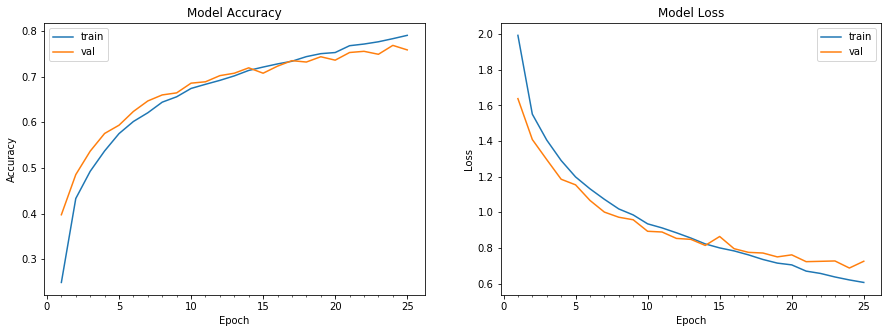

Accuracy on test data is: 75.87


In [14]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 512),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 25, 
                                 validation_data = (test_features, test_labels), callbacks=[reduce_lr], verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))